# HW 5 Question 2 Nonlinear Advection-Diffusion-Reaction Inverse problem

In [ ]:
import dolfin as dl
import numpy as np

import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_DIR', "../../") )

from hippylib import *

import logging

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.family': 'Times'})

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

# create mesh, define function spaces, and functions

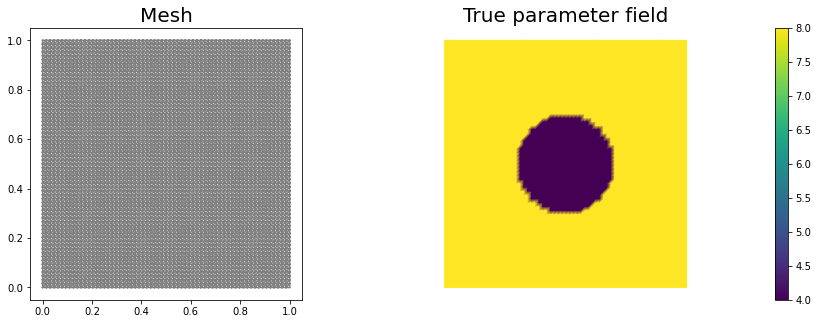

In [2]:
nx = 64
ny = 64
mesh = dl.UnitSquareMesh(nx, ny)
Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

# The true and initial guess inverted parameter
mtrue = dl.interpolate(dl.Expression('8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) )', degree=5), Vm)

# define function for state and adjoint
u = dl.Function(Vu)
m = dl.Function(Vm)
p = dl.Function(Vu)

# define Trial and Test Functions
u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

# initialize input functions
f = dl.interpolate(dl.Expression('std::max(0.5, exp(-25*(x[0]-0.7)*(x[0]-0.7) - 25 * (x[1]-0.7)*(x[1]-0.7)))', degree=2), Vu)
v  = dl.Constant((1.0, 0.0))#advective velocity vector
u0 = dl.Constant(0.0)       #BC
k  = dl.Constant(1.0)       #Diffusion parameter

# plot
plt.figure(figsize=(15,5))
nb.plot(mesh,subplot_loc=121, mytitle="Mesh", show_axis='on')
nb.plot(mtrue,subplot_loc=122, mytitle="True parameter field")
plt.show()

In [3]:
# set up dirichlet boundary conditions
def boundary(x,on_boundary):
    return on_boundary

bc_state = dl.DirichletBC(Vu, u0, boundary)
bc_adj = dl.DirichletBC(Vu, dl.Constant(0.), boundary)

In [24]:
# Class HessianOperator to perform Hessian apply to a vector
class HessianOperator():
    cgiter = 0
    def __init__(self, R, Wmm, C, A, adj_A, W, Wum, bc0, use_gaussnewton=False):
        self.R = R
        self.Wmm = Wmm
        self.C = C
        self.A = A
        self.adj_A = adj_A
        self.W = W
        self.Wum = Wum
        self.bc0 = bc0
        self.use_gaussnewton = use_gaussnewton
        
        # incremental state
        self.du = dl.Vector()
        self.A.init_vector(self.du,0)
        
        #incremental adjoint
        self.dp = dl.Vector()
        self.adj_A.init_vector(self.dp,0)
        
        # auxiliary vector
        self.Wum_du = dl.Vector()
        self.Wum.init_vector(self.Wum_du, 1)
        
    def init_vector(self, v, dim):
        self.R.init_vector(v,dim)

    # Hessian performed on v, output as generic vector y
    def mult(self, v, y):
        self.cgiter += 1
        y.zero()
        if self.use_gaussnewton:
            self.mult_GaussNewton(v,y)
        else:
            self.mult_Newton(v,y)
            
    # define (Gauss-Newton) Hessian apply H * v
    def mult_GaussNewton(self, v, y):
        
        #incremental forward
        rhs = -(self.C * v)
        self.bc0.apply(rhs)
        dl.solve (self.A, self.du, rhs)
        
        #incremental adjoint
        rhs = - (self.W * self.du)
        self.bc0.apply(rhs)
        dl.solve (self.adj_A, self.dp, rhs)
                
        # Misfit term
        self.C.transpmult(self.dp, y)
        
        if self.R:
            Rv = self.R*v
            y.axpy(1, Rv)
        
    # define (Newton) Hessian apply H * v
    def mult_Newton(self, v, y):
        
        #incremental forward
        rhs = -(self.C * v)
        self.bc0.apply(rhs)
        dl.solve (self.A, self.du, rhs)
        
        #incremental adjoint
        rhs = -(self.W * self.du) -  self.Wum * v
        self.bc0.apply(rhs)
        dl.solve (self.adj_A, self.dp, rhs)
                
        #Misfit term
        self.C.transpmult(self.dp, y)
        
        self.Wum.transpmult(self.du, self.Wum_du)
        y.axpy(1., self.Wum_du)
        
        y.axpy(1., self.Wmm*v)
        
        #Reg/Prior term
        if self.R:
            y.axpy(1., self.R*v)
        

In [44]:
def AddDiffInverseProblem(nx, ny, gamma, v, morozov = False, plot = True, noise_level=0.01, useTV=False):
    np.random.seed(seed=1)
    mesh = dl.UnitSquareMesh(nx, ny)
    Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
    Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

    # The true and initial guess inverted parameter
    mtrue = dl.interpolate(dl.Expression('8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) )', degree=5), Vm)

    # define function for state and adjoint
    u = dl.Function(Vu)
    m = dl.Function(Vm)
    p = dl.Function(Vu)

    # define Trial and Test Functions
    u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
    u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

    # initialize input functions
    f = dl.interpolate(dl.Expression('std::max(0.5, exp(-25*(x[0]-0.7)*(x[0]-0.7) - 25 * (x[1]-0.7)*(x[1]-0.7)))', degree=2), Vu)
    v = dl.Constant((1.0, 0.0))
    k = dl.Constant(1.0)
    u0 = dl.Constant(0.0)    
    
    # set up dirichlet boundary conditions
    def boundary(x,on_boundary):
        return on_boundary

    bc_state = dl.DirichletBC(Vu, u0, boundary)
    bc_adj = dl.DirichletBC(Vu, dl.Constant(0.), boundary)

    
    a_true = dl.inner( dl.exp(mtrue) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx \
            + dl.dot(v, dl.grad(u_trial))*u_test*dl.dx
    L_true = f * u_test * dl.dx
    A_true, b_true = dl.assemble_system(a_true, L_true, bc_state)

    utrue = dl.Function(Vu)
    
    F = k*dl.inner(dl.grad(utrue), dl.grad(u_test)) * dl.dx + \
    dl.inner(v, dl.grad(utrue)) * u_test * dl.dx + \
    100*dl.exp(mtrue)*utrue*utrue*utrue*u_test * dl.dx - \
    f*u_test*dl.dx
    
    dl.solve(F == 0, utrue, bc_state, solver_parameters={"newton_solver": \
                                                     {"relative_tolerance": 1e-6}})    

    ud = dl.Function(Vu)
    ud.assign(utrue)

    # perturb state solution and create synthetic measurements ud
    # ud = u + ||u||/SNR * random.normal
    MAX = ud.vector().norm("linf")
    noise = dl.Vector()
    A_true.init_vector(noise,1)
    noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(ud.vector().get_local())) )
    bc_adj.apply(noise)

    ud.vector().axpy(1., noise)
    
    # define cost function
    def cost(u, ud, m,gamma):
        if useTV:
            reg = gamma * dl.assemble( dl.sqrt(dl.inner(dl.grad(m), dl.grad(m)) + TVeps)*dl.dx ) 
        else:
            reg = 0.5* gamma * dl.assemble( dl.inner(dl.grad(m), dl.grad(m))*dl.dx )
            
        misfit = 0.5 * dl.assemble( (u-ud)**2*dl.dx)
        return [reg + misfit, misfit, reg]
    
    # weak form for setting up the state equation
    
    F_state = dl.inner(k * dl.grad(u) , dl.grad(p_test)) * dl.dx + \
          dl.dot(v, dl.grad(u)) * p_test * dl.dx + \
          dl.Constant(100)*dl.exp(m) * u**3 * p_test * dl.dx - \
          f * p_test * dl.dx

    # weak form for gradient
    CTvarf = dl.inner(dl.Constant(100) * m_trial* dl.exp(m) * u**3, p_test) * dl.dx 
    gradRvarf = dl.Constant(gamma)*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx

    # L^2 weighted inner product
    M_varf   = dl.inner(m_trial, m_test) * dl.dx
    M = dl.assemble(M_varf)    
    
    # weak form for setting up the adjoint equation
    
    F_adj = (u - ud) * u_test * dl.dx + k * dl.inner(dl.grad(u_test), dl.grad(p)) * dl.dx + \
    dl.dot(v, dl.grad(u_test)) * p * dl.dx + dl.Constant(300) * dl.exp(m) * u * u * u_test * p * dl.dx

    
    # weak form for gradient
    TVeps = 0.001
    
    CTvarf = dl.Constant(100) * m_test * dl.exp(m) * u**3 * p * dl.dx
    if useTV:
        gradRvarf = ( dl.Constant(gamma)/dl.sqrt(dl.inner(dl.grad(m), dl.grad(m)) + TVeps) )* \
                     dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx
    else:
        gradRvarf = dl.Constant(gamma)*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx    
    
    # L^2 weighted inner product
    M_varf   = dl.inner(m_trial, m_test) * dl.dx
    M = dl.assemble(M_varf)
    
    m0 = dl.interpolate(dl.Constant(4.), Vm )
    m.assign(m0)

    # solve state equation
    dl.solve(F_state == 0, u, bc_state, solver_parameters={"newton_solver": {"relative_tolerance": 1e-6}})
    
    uk = dl.Function(Vu)
    #pk = dl.Function(Vu)

    #dl.solve(F_adj == 0, p, bc_adj, solver_parameters={"newton_solver": {"relative_tolerance": 1e-6}})
    
    '''
    
    dl.solve (state_A, u.vector(), state_b)
    '''
    
    # evaluate cost
    [cost_old, misfit_old, reg_old] = cost(u, ud, m, gamma)
    
    #Hessian varfs
    W_varf   = dl.inner(u_trial, u_test) * dl.dx
    R_varf   = dl.Constant(gamma) * dl.inner(dl.grad(m_trial), dl.grad(m_test)) * dl.dx

    #C_varf   = dl.inner(dl.Constant(100) * dl.exp(m) * m_trial * u**3, u_test) * dl.dx
    C_varf = dl.inner(dl.Constant(100) * m_trial* dl.exp(m) * u**3, p_test) * dl.dx 
    Wum_varf = dl.inner(dl.Constant(300) * dl.exp(m) * m_trial * u * u * u_test, p) * dl.dx
    Wmm_varf = dl.inner(dl.Constant(100) * dl.exp(m) * m_trial * m_test *  u**3,  p) * dl.dx

    a_adj = dl.inner(k * dl.grad(u_test), dl.grad(p_trial)) * dl.dx + \
            dl.inner(dl.dot(v, dl.grad(u_test)), p_trial) * dl.dx + \
            dl.inner(dl.Constant(300) * dl.exp(m) * u * u * u_test, p_trial) * dl.dx


    a_state = dl.inner(k * dl.grad(u_trial), dl.grad(p_test)) * dl.dx + \
              dl.inner(dl.dot(v, dl.grad(u_trial)), p_test) * dl.dx + \
              dl.inner(dl.Constant(300) * dl.exp(m) * u * u * u_trial, p_test) * dl.dx
    #          dl.inner(dl.Constant(100) * m_trial * dl.exp(m) * u * u * u, u_test) * dl.dx

    #L_state = dl.Constant(0.) * u_test * dl.dx


    
    # Assemble constant matrices
    W = dl.assemble(W_varf)
    R = dl.assemble(R_varf)
    
    # define parameters for the optimization
    tol = 5e-7
    c = 1e-4
    maxiter = 20

    # initialize iter counters
    iter = 1
    total_cg_iter = 0
    converged = False

    # initializations
    g, m_delta = dl.Vector(), dl.Vector()
    R.init_vector(m_delta,0)
    R.init_vector(g,0)

    m_prev = dl.Function(Vm)

    print( "Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg" )

    while iter <  maxiter and not converged:

        # solve the adoint problem
        
        dl.solve(F_adj == 0, p, bc_adj, solver_parameters={"newton_solver": {"relative_tolerance": 1e-6}})
        
        #state_A, state_b = dl.assemble_system (a_state, L_state, bc_state)
        a_adj = dl.inner(k * dl.grad(u_test), dl.grad(p_trial)) * dl.dx + \
            dl.inner(dl.dot(v, dl.grad(u_test)), p_trial) * dl.dx + \
            dl.inner(dl.Constant(300) * dl.exp(m) * u * u * u_test, p_trial) * dl.dx
        
        
        adjoint_A , _= dl.assemble_system(a_adj, dl.Constant(0.) * p_test * dl.dx, bc_adj)
        
        a_state = dl.inner(k * dl.grad(u_trial), dl.grad(p_test)) * dl.dx + \
              dl.inner(dl.dot(v, dl.grad(u_trial)), p_test) * dl.dx + \
              dl.inner(dl.Constant(300) * dl.exp(m) * u * u * u_trial, p_test) * dl.dx

        
        state_A , _= dl.assemble_system(a_state, dl.Constant(0.) * u_test * dl.dx, bc_state)
        #state_A = dl.assemble(a_state)
        
        #adjoint_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
        #dl.solve(adjoint_A, p.vector(), adjoint_RHS)
        
        # evaluate the  gradient
        MG = dl.assemble(CTvarf + gradRvarf)

        # calculate the L^2 norm of the gradient
        dl.solve(M, g, MG)
        grad2 = g.inner(MG)
        gradnorm = np.sqrt(grad2)

        # set the CG tolerance (use Eisenstat–Walker termination criterion)
        if iter == 1:
            gradnorm_ini = gradnorm
        tolcg = min(0.5, np.sqrt(gradnorm/gradnorm_ini))
    
        # assemble W_um and W_mm
        C   = dl.assemble(C_varf)
        Wum = dl.assemble(Wum_varf)
        Wmm = dl.assemble(Wmm_varf)

        # define the Hessian apply operator (with preconditioner)
        Hess_Apply = HessianOperator(R, Wmm, C, state_A, adjoint_A, W, Wum, bc_adj, use_gaussnewton=(iter<6) )
        P = R + 0.1*gamma * M
        Psolver = dl.PETScKrylovSolver("cg", amg_method())
        Psolver.set_operator(P)
    
        solver = CGSolverSteihaug()
        solver.set_operator(Hess_Apply)
        solver.set_preconditioner(Psolver)
        solver.parameters["rel_tolerance"] = tolcg
        solver.parameters["zero_initial_guess"] = True
        solver.parameters["print_level"] = -1

        # solve the Newton system H a_delta = - MG
        solver.solve(m_delta, -MG)
        total_cg_iter += Hess_Apply.cgiter
    
        # linesearch
        alpha = 1
        descent = 0
        no_backtrack = 0
        m_prev.assign(m)
        while descent == 0 and no_backtrack < 10:
            m.vector().axpy(alpha, m_delta )

            # solve the state/forward problem
            dl.solve(F_state == 0, u, bc_state, solver_parameters={"newton_solver": {"relative_tolerance": 1e-5}})
            a_state = dl.inner(k * dl.grad(u_trial), dl.grad(p_test)) * dl.dx + \
              dl.inner(dl.dot(v, dl.grad(u_trial)), p_test) * dl.dx + \
              dl.inner(dl.Constant(300) * dl.exp(m) * u * u * u_trial, p_test) * dl.dx
    
            
            state_A = dl.assemble(a_state)
            
            #state_A, state_b = dl.assemble_system(a_state, L_state, bc_state)
            #dl.solve(state_A, u.vector(), state_b)
            
            # evaluate cost
            [cost_new, misfit_new, reg_new] = cost(u, ud, m, gamma)

            # check if Armijo conditions are satisfied
            if cost_new < cost_old + alpha * c * MG.inner(m_delta):
                cost_old = cost_new
                descent = 1
            else:
                no_backtrack += 1
                alpha *= 0.5
                m.assign(m_prev)  # reset a

        # calculate sqrt(-G * D)
        graddir = np.sqrt(- MG.inner(m_delta) )

        sp = ""
        print( "%2d %2s %2d %3s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %5.2f %1s %5.3e" % \
            (iter, sp, Hess_Apply.cgiter, sp, cost_new, sp, misfit_new, sp, reg_new, sp, \
             graddir, sp, gradnorm, sp, alpha, sp, tolcg) )

        # check for convergence
        if gradnorm < tol and iter > 1:
            converged = True
            print( "Newton's method converged in ",iter,"  iterations" )
            print( "Total number of CG iterations: ", total_cg_iter )
        
        iter += 1
    
    if not converged:
        print( "Newton's method did not converge in ", maxiter, " iterations" )
    
    if plot:
        nb.multi1_plot([mtrue, m], ["mtrue", "m"])
        if useTV:
            plt.savefig("HW5_Q2_TV_%.1e_%.1e_.pdf" %(nx,gamma)) 
        else:
            plt.savefig("HW5_Q2_TN_%.1e_%.1e_.pdf" %(nx,gamma))        
        plt.show()
    
    Mstate = dl.assemble(u_trial*u_test*dl.dx)
    noise_norm2 = noise.inner(Mstate*noise)

    if not morozov:
        Hmisfit = HessianOperator(None, Wmm, C, state_A, adjoint_A, W, Wum, bc_adj, use_gaussnewton=True)
        k = 50
        p = 20

        Omega = MultiVector(m.vector(), k+p)
        parRandom.normal(1., Omega)
        lmbda, evecs = doublePassG(Hmisfit, P, Psolver, Omega, k)

        plt.plot(range(0,k), lmbda, 'b*', range(0,k+1), np.ones(k+1), '-r')
        plt.yscale('log')
        plt.xlabel('number')
        plt.ylabel('eigenvalue')
        plt.show()

        nb.plot_eigenvectors(Vm, evecs, mytitle="Eigenvector", which=[0,1,2,5,10,15])
        plt.show()

        
    
    return Vm.dim(), iter, total_cg_iter, noise_norm2, cost_new, misfit_new, reg_new

# Part 2.2: FEniCS implementation of the inexact Newton and Gauss-Newton methods

****** Computing solution with gamma =  1e-07 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40043e-06   2.40011e-06   3.17859e-10   8.35779e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87596e-07   8.87394e-07   2.01775e-10   1.71777e-03   6.61722e-06    1.00   4.753e-01
 3     2     6.40774e-07   4.93711e-07   1.47063e-07   7.08506e-04   2.47713e-06    1.00   2.908e-01
 4     2     6.23460e-07   4.75595e-07   1.47865e-07   1.85464e-04   6.29992e-07    1.00   1.466e-01
 5     3     6.22202e-07   4.53490e-07   1.68712e-07   4.99122e-05   1.74728e-07    1.00   7.723e-02
 6     5     6.22188e-07   4.54203e-07   1.67985e-07   5.35451e-06   2.86138e-08    1.00   3.125e-02
 7     5     6.22188e-07   4.54175e-07   1.68012e-07   1.13723e-07   4.85920e-10    1.00   4.073e-03
Newton's method converged in  7   iterations
Total number of CG iterations:  19


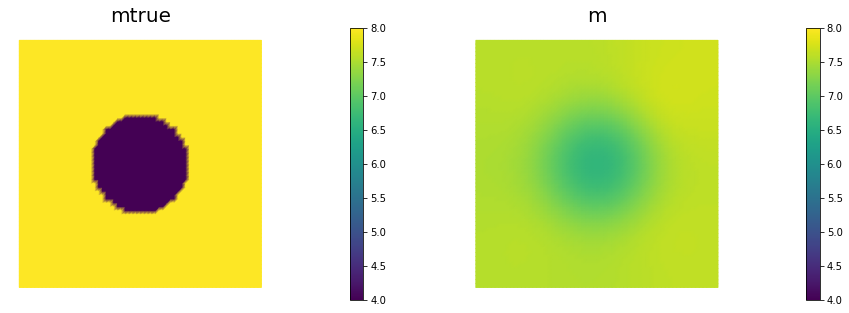

****** Computing solution with gamma =  1e-08 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40026e-06   2.40023e-06   3.17864e-11   8.35782e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87438e-07   8.87418e-07   2.02721e-11   1.71776e-03   6.57852e-06    1.00   4.739e-01
 3     4     2.58000e-07   1.29821e-07   1.28179e-07   1.17692e-03   2.45624e-06    1.00   2.896e-01
 4     1     2.22724e-07   9.45056e-08   1.28218e-07   2.65630e-04   9.53987e-07    1.00   1.805e-01
 5     8     2.17274e-07   8.84267e-08   1.28847e-07   1.06269e-04   2.18875e-07    1.00   8.644e-02
 6     5     2.17229e-07   8.88363e-08   1.28392e-07   9.52830e-06   2.05604e-08    1.00   2.649e-02
 7    11     2.17227e-07   8.87431e-08   1.28484e-07   1.54419e-06   3.82498e-09    1.00   1.143e-02
Newton's method converged in  7   iterations
Total number of CG iterations:  31


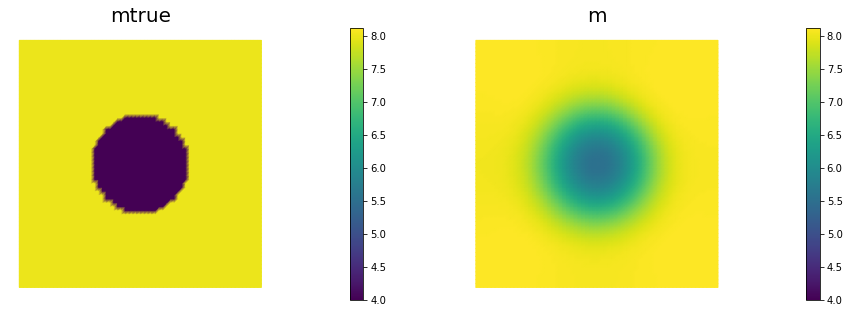

****** Computing solution with gamma =  1e-09 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40025e-06   2.40025e-06   3.17864e-12   8.35782e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87422e-07   8.87420e-07   2.02816e-12   1.71776e-03   6.57466e-06    1.00   4.738e-01
 3     4     1.57640e-07   1.38912e-07   1.87278e-08   1.28998e-03   2.45417e-06    1.00   2.894e-01
 4     1     8.16579e-08   6.29227e-08   1.87352e-08   3.90046e-04   1.32922e-06    1.00   2.130e-01
 5    10     5.67562e-08   2.60760e-08   3.06802e-08   2.36372e-04   3.08177e-07    1.00   1.026e-01
 6     1     5.56556e-08   2.49750e-08   3.06806e-08   4.71613e-05   1.73272e-07    1.00   7.691e-02
 7    18     5.44608e-08   2.32601e-08   3.12008e-08   4.89628e-05   5.74841e-08    1.00   4.430e-02
 8     1     5.44574e-08   2.32566e-08   3.12008e-08   2.62863e-06   1.07642e-08    1.00   1.917e-02
 9    32     5.44499e-08   2.33249e-08   3

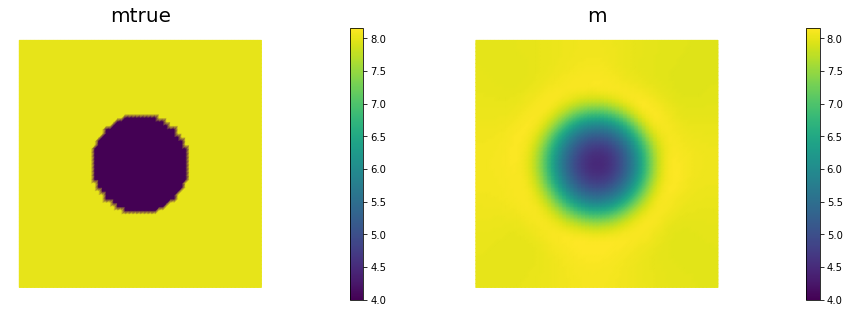

****** Computing solution with gamma =  1e-10 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40024e-06   2.40024e-06   3.17743e-13   8.35783e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87410e-07   8.87410e-07   2.02753e-13   1.71777e-03   6.57428e-06    1.00   4.737e-01
 3     4     1.46148e-07   1.44195e-07   1.95357e-09   1.30326e-03   2.45394e-06    1.00   2.894e-01
 4     1     6.33682e-08   6.14138e-08   1.95437e-09   4.07134e-04   1.38062e-06    1.00   2.171e-01
 5    15     2.97626e-08   2.53070e-08   4.45568e-09   2.96945e-04   3.29999e-07    1.00   1.061e-01
 6     1     2.18906e-08   1.74348e-08   4.45575e-09   1.27439e-04   4.70462e-07    1.00   1.267e-01
 7    15     1.94352e-08   1.39266e-08   5.50857e-09   6.84750e-05   6.83532e-08    1.00   4.831e-02
 8     1     1.93752e-08   1.38666e-08   5.50858e-09   1.09669e-05   4.51165e-08    1.00   3.924e-02
 9    58     1.89616e-08   1.31136e-08   5

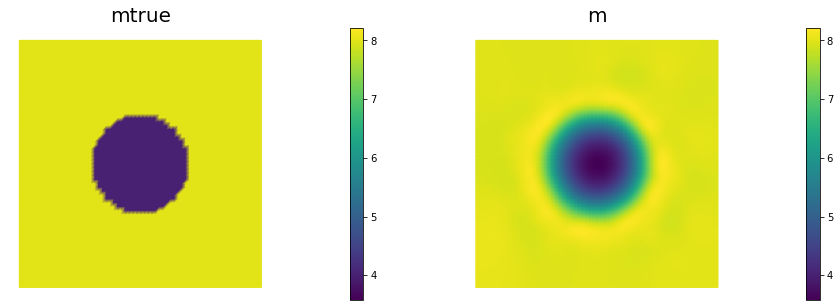

****** Computing solution with gamma =  1e-11 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40024e-06   2.40024e-06   3.17742e-14   8.35783e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87409e-07   8.87409e-07   2.02755e-14   1.71777e-03   6.57424e-06    1.00   4.737e-01
 3     3     1.43043e-07   1.42846e-07   1.96182e-10   1.30445e-03   2.45391e-06    1.00   2.894e-01
 4     1     6.14971e-08   6.13008e-08   1.96262e-10   4.04086e-04   1.37045e-06    1.00   2.163e-01
 5    14     2.71881e-08   2.67214e-08   4.66674e-10   3.04506e-04   3.32372e-07    1.00   1.065e-01
 6     1     1.76460e-08   1.71793e-08   4.66681e-10   1.40558e-04   5.18053e-07    1.00   1.330e-01
 7    14     1.40935e-08   1.34686e-08   6.24830e-10   8.11226e-05   7.83342e-08    1.00   5.171e-02
 8     1     1.39398e-08   1.33150e-08   6.24831e-10   1.75661e-05   7.02408e-08    1.00   4.897e-02
 9    153     1.39151e-08   1.32877e-08   

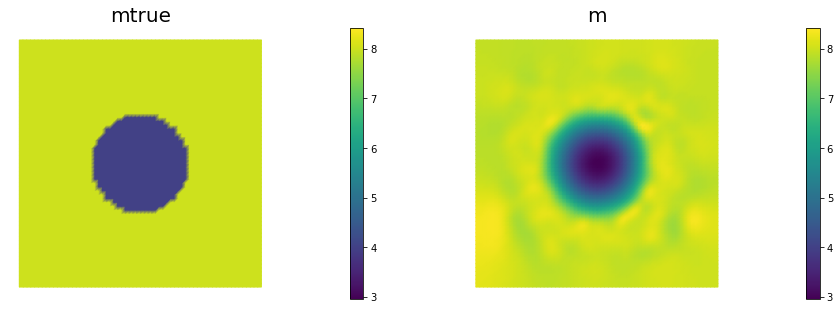

In [10]:
n = 20
gammas = [1e-7, 1e-8, 1e-9, 1e-10, 1e-11]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(nx, ny, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=False)



****** Computing solution with gamma =  1e-07 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40043e-06   2.40011e-06   3.17859e-10   8.35779e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87596e-07   8.87394e-07   2.01775e-10   1.71777e-03   6.61722e-06    1.00   4.753e-01
 3     2     6.40774e-07   4.93711e-07   1.47063e-07   7.08506e-04   2.47713e-06    1.00   2.908e-01
 4     2     6.23460e-07   4.75595e-07   1.47865e-07   1.85464e-04   6.29992e-07    1.00   1.466e-01
 5     3     6.22202e-07   4.53490e-07   1.68712e-07   4.99122e-05   1.74728e-07    1.00   7.723e-02
 6     5     6.22188e-07   4.54203e-07   1.67985e-07   5.35451e-06   2.86138e-08    1.00   3.125e-02
 7     5     6.22188e-07   4.54175e-07   1.68012e-07   1.13723e-07   4.85920e-10    1.00   4.073e-03
Newton's method converged in  7   iterations
Total number of CG iterations:  19


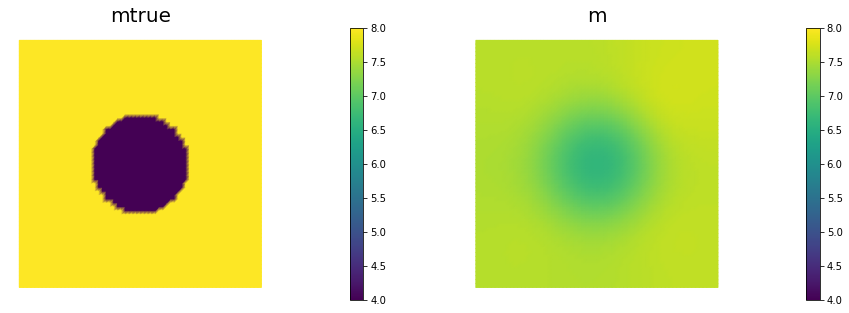

****** Computing solution with gamma =  1e-08 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40026e-06   2.40023e-06   3.17864e-11   8.35782e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87438e-07   8.87418e-07   2.02721e-11   1.71776e-03   6.57852e-06    1.00   4.739e-01
 3     4     2.58000e-07   1.29821e-07   1.28179e-07   1.17692e-03   2.45624e-06    1.00   2.896e-01
 4     1     2.22724e-07   9.45056e-08   1.28218e-07   2.65630e-04   9.53987e-07    1.00   1.805e-01
 5     8     2.17274e-07   8.84267e-08   1.28847e-07   1.06269e-04   2.18875e-07    1.00   8.644e-02
 6     5     2.17229e-07   8.88363e-08   1.28392e-07   9.52830e-06   2.05604e-08    1.00   2.649e-02
 7    11     2.17227e-07   8.87431e-08   1.28484e-07   1.54419e-06   3.82498e-09    1.00   1.143e-02
Newton's method converged in  7   iterations
Total number of CG iterations:  31


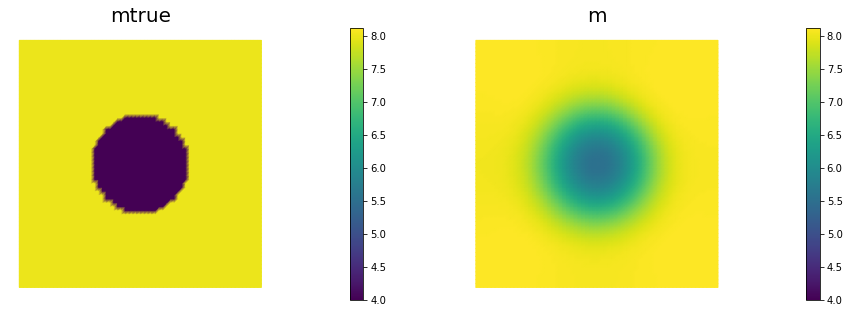

****** Computing solution with gamma =  1e-09 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40025e-06   2.40025e-06   3.17864e-12   8.35782e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87422e-07   8.87420e-07   2.02816e-12   1.71776e-03   6.57466e-06    1.00   4.738e-01
 3     4     1.57640e-07   1.38912e-07   1.87278e-08   1.28998e-03   2.45417e-06    1.00   2.894e-01
 4     1     8.16579e-08   6.29227e-08   1.87352e-08   3.90046e-04   1.32922e-06    1.00   2.130e-01
 5    10     5.67562e-08   2.60760e-08   3.06802e-08   2.36372e-04   3.08177e-07    1.00   1.026e-01
 6     1     5.56556e-08   2.49750e-08   3.06806e-08   4.71613e-05   1.73272e-07    1.00   7.691e-02
 7    18     5.44608e-08   2.32601e-08   3.12008e-08   4.89628e-05   5.74841e-08    1.00   4.430e-02
 8     1     5.44574e-08   2.32566e-08   3.12008e-08   2.62863e-06   1.07642e-08    1.00   1.917e-02
 9    32     5.44499e-08   2.33249e-08   3

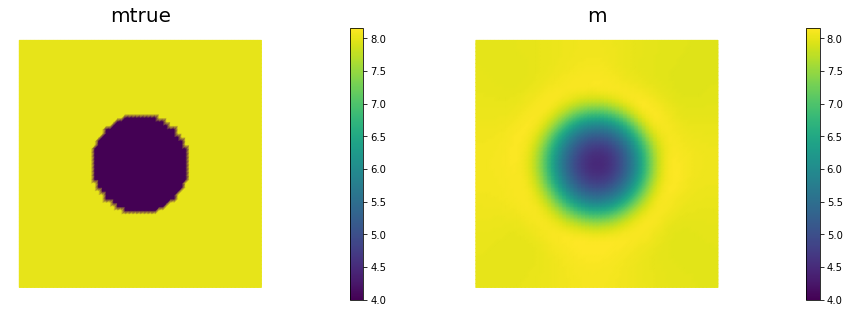

****** Computing solution with gamma =  1e-10 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40024e-06   2.40024e-06   3.17743e-13   8.35783e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87410e-07   8.87410e-07   2.02753e-13   1.71777e-03   6.57428e-06    1.00   4.737e-01
 3     4     1.46148e-07   1.44195e-07   1.95357e-09   1.30326e-03   2.45394e-06    1.00   2.894e-01
 4     1     6.33682e-08   6.14138e-08   1.95437e-09   4.07134e-04   1.38062e-06    1.00   2.171e-01
 5    15     2.97626e-08   2.53070e-08   4.45568e-09   2.96945e-04   3.29999e-07    1.00   1.061e-01
 6     1     2.18906e-08   1.74348e-08   4.45575e-09   1.27439e-04   4.70462e-07    1.00   1.267e-01
 7    15     1.94352e-08   1.39266e-08   5.50857e-09   6.84750e-05   6.83532e-08    1.00   4.831e-02
 8     1     1.93752e-08   1.38666e-08   5.50858e-09   1.09669e-05   4.51165e-08    1.00   3.924e-02
 9    58     1.89616e-08   1.31136e-08   5

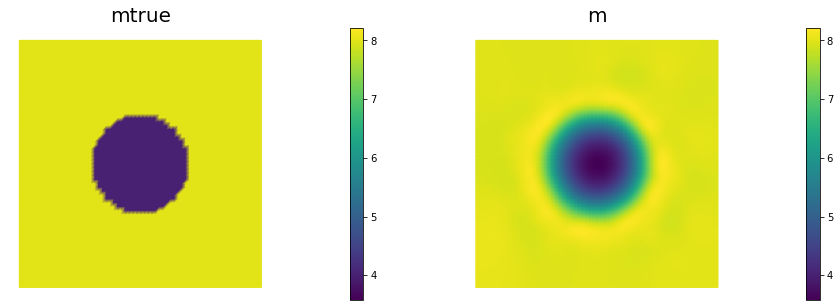

In [11]:
n = 40
gammas = [1e-7, 1e-8, 1e-9, 1e-10]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(nx, ny, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=False)

****** Computing solution with gamma =  1e-07 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40043e-06   2.40011e-06   3.17859e-10   8.35779e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87596e-07   8.87394e-07   2.01775e-10   1.71777e-03   6.61722e-06    1.00   4.753e-01
 3     2     6.40774e-07   4.93711e-07   1.47063e-07   7.08506e-04   2.47713e-06    1.00   2.908e-01
 4     2     6.23460e-07   4.75595e-07   1.47865e-07   1.85464e-04   6.29992e-07    1.00   1.466e-01
 5     3     6.22202e-07   4.53490e-07   1.68712e-07   4.99122e-05   1.74728e-07    1.00   7.723e-02
 6     5     6.22188e-07   4.54203e-07   1.67985e-07   5.35451e-06   2.86138e-08    1.00   3.125e-02
 7     5     6.22188e-07   4.54175e-07   1.68012e-07   1.13723e-07   4.85920e-10    1.00   4.073e-03
Newton's method converged in  7   iterations
Total number of CG iterations:  19


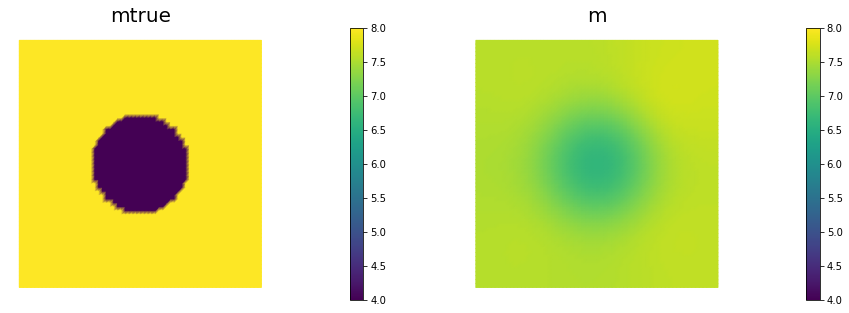

****** Computing solution with gamma =  1e-08 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40026e-06   2.40023e-06   3.17864e-11   8.35782e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87438e-07   8.87418e-07   2.02721e-11   1.71776e-03   6.57852e-06    1.00   4.739e-01
 3     4     2.58000e-07   1.29821e-07   1.28179e-07   1.17692e-03   2.45624e-06    1.00   2.896e-01
 4     1     2.22724e-07   9.45056e-08   1.28218e-07   2.65630e-04   9.53987e-07    1.00   1.805e-01
 5     8     2.17274e-07   8.84267e-08   1.28847e-07   1.06269e-04   2.18875e-07    1.00   8.644e-02
 6     5     2.17229e-07   8.88363e-08   1.28392e-07   9.52830e-06   2.05604e-08    1.00   2.649e-02
 7    11     2.17227e-07   8.87431e-08   1.28484e-07   1.54419e-06   3.82498e-09    1.00   1.143e-02
Newton's method converged in  7   iterations
Total number of CG iterations:  31


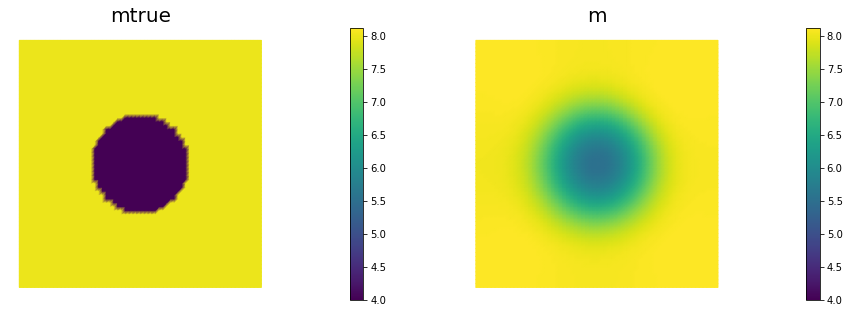

****** Computing solution with gamma =  1e-09 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40025e-06   2.40025e-06   3.17864e-12   8.35782e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87422e-07   8.87420e-07   2.02816e-12   1.71776e-03   6.57466e-06    1.00   4.738e-01
 3     4     1.57640e-07   1.38912e-07   1.87278e-08   1.28998e-03   2.45417e-06    1.00   2.894e-01
 4     1     8.16579e-08   6.29227e-08   1.87352e-08   3.90046e-04   1.32922e-06    1.00   2.130e-01
 5    10     5.67562e-08   2.60760e-08   3.06802e-08   2.36372e-04   3.08177e-07    1.00   1.026e-01
 6     1     5.56556e-08   2.49750e-08   3.06806e-08   4.71613e-05   1.73272e-07    1.00   7.691e-02
 7    18     5.44608e-08   2.32601e-08   3.12008e-08   4.89628e-05   5.74841e-08    1.00   4.430e-02
 8     1     5.44574e-08   2.32566e-08   3.12008e-08   2.62863e-06   1.07642e-08    1.00   1.917e-02
 9    32     5.44499e-08   2.33249e-08   3

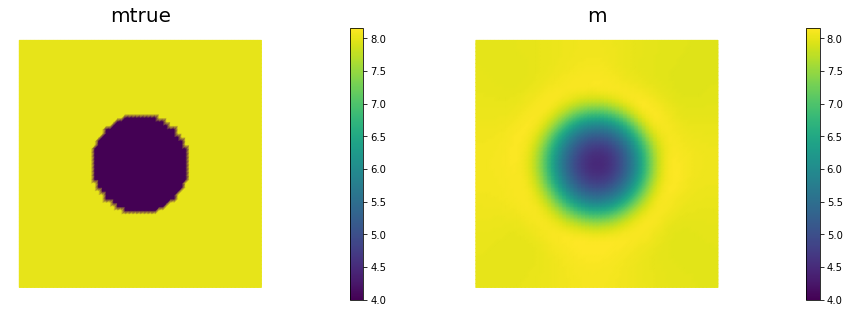

****** Computing solution with gamma =  1e-10 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40024e-06   2.40024e-06   3.17743e-13   8.35783e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87410e-07   8.87410e-07   2.02753e-13   1.71777e-03   6.57428e-06    1.00   4.737e-01
 3     4     1.46148e-07   1.44195e-07   1.95357e-09   1.30326e-03   2.45394e-06    1.00   2.894e-01
 4     1     6.33682e-08   6.14138e-08   1.95437e-09   4.07134e-04   1.38062e-06    1.00   2.171e-01
 5    15     2.97626e-08   2.53070e-08   4.45568e-09   2.96945e-04   3.29999e-07    1.00   1.061e-01
 6     1     2.18906e-08   1.74348e-08   4.45575e-09   1.27439e-04   4.70462e-07    1.00   1.267e-01
 7    15     1.94352e-08   1.39266e-08   5.50857e-09   6.84750e-05   6.83532e-08    1.00   4.831e-02
 8     1     1.93752e-08   1.38666e-08   5.50858e-09   1.09669e-05   4.51165e-08    1.00   3.924e-02
 9    58     1.89616e-08   1.31136e-08   5

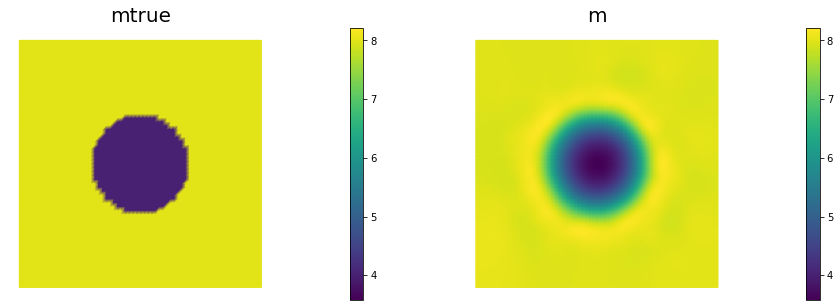

In [12]:
n = 80
gammas = [1e-7, 1e-8, 1e-9, 1e-10]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(nx, ny, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=False)

# Part 2.3: Consider two noise levels: low noise (1%) and high noise (10%) and find the optimal parameter

****** Computing solution with gamma =  1e-07 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     3.55426e-06   3.55394e-06   3.17321e-10   8.34764e-03   2.92667e-05    1.00   5.000e-01
 2     1     2.03561e-06   2.03541e-06   2.01818e-10   1.72174e-03   6.60713e-06    1.00   4.751e-01
 3     2     1.79682e-06   1.65434e-06   1.42485e-07   6.97126e-04   2.44112e-06    1.00   2.888e-01
 4     2     1.78042e-06   1.63730e-06   1.43130e-07   1.80464e-04   6.09536e-07    1.00   1.443e-01
 5     3     1.77927e-06   1.61658e-06   1.62697e-07   4.77743e-05   1.70045e-07    1.00   7.622e-02
 6     5     1.77926e-06   1.61727e-06   1.61991e-07   5.04956e-06   2.74448e-08    1.00   3.062e-02
 7     7     1.77926e-06   1.61724e-06   1.62017e-07   1.16674e-07   4.84104e-10    1.00   4.067e-03
Newton's method converged in  7   iterations
Total number of CG iterations:  21


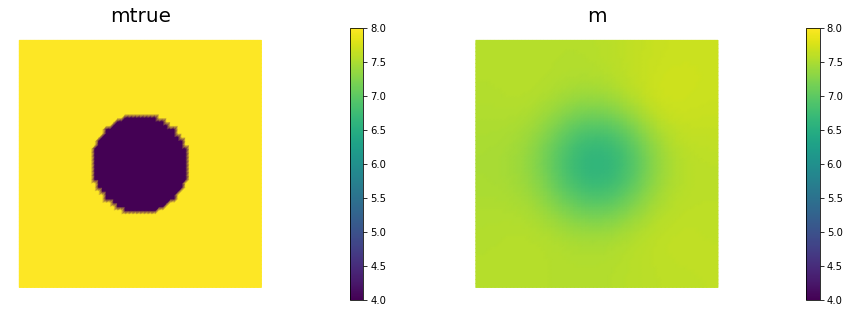

****** Computing solution with gamma =  1e-08 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     3.55410e-06   3.55407e-06   3.17326e-11   8.34767e-03   2.92667e-05    1.00   5.000e-01
 2     1     2.03546e-06   2.03544e-06   2.02761e-11   1.72173e-03   6.56856e-06    1.00   4.737e-01
 3     4     1.42722e-06   1.30329e-06   1.23926e-07   1.15705e-03   2.42046e-06    1.00   2.876e-01
 4     1     1.39383e-06   1.26986e-06   1.23963e-07   2.58456e-04   9.27779e-07    1.00   1.780e-01
 5     8     1.38753e-06   1.26119e-06   1.26337e-07   1.13602e-04   2.35454e-07    1.00   8.969e-02
 6     7     1.38748e-06   1.26200e-06   1.25474e-07   1.03452e-05   2.23087e-08    1.00   2.761e-02
 7    10     1.38747e-06   1.26193e-06   1.25542e-07   1.64855e-06   4.26745e-09    1.00   1.208e-02
Newton's method converged in  7   iterations
Total number of CG iterations:  32


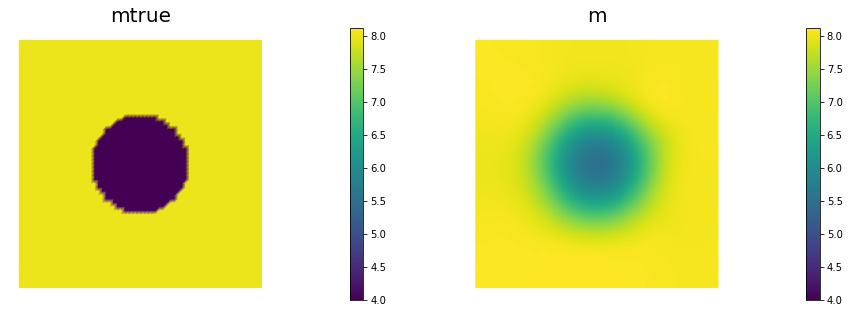

****** Computing solution with gamma =  1e-09 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     3.55408e-06   3.55408e-06   3.17327e-12   8.34768e-03   2.92667e-05    1.00   5.000e-01
 2     1     2.03544e-06   2.03544e-06   2.02855e-12   1.72173e-03   6.56471e-06    1.00   4.736e-01
 3     4     1.32980e-06   1.31168e-06   1.81130e-08   1.26826e-03   2.41841e-06    1.00   2.875e-01
 4     1     1.25783e-06   1.23971e-06   1.81200e-08   3.79608e-04   1.29551e-06    1.00   2.104e-01
 5    10     1.22817e-06   1.19601e-06   3.21565e-08   2.59405e-04   3.33872e-07    1.00   1.068e-01
 6     1     1.22639e-06   1.19424e-06   3.21568e-08   5.99832e-05   2.19552e-07    1.00   8.661e-02
 7    16     1.22467e-06   1.19176e-06   3.29124e-08   5.87605e-05   7.04270e-08    1.00   4.905e-02
 8     1     1.22466e-06   1.19175e-06   3.29125e-08   4.21415e-06   1.80913e-08    1.00   2.486e-02
 9    29     1.22463e-06   1.19178e-06   3

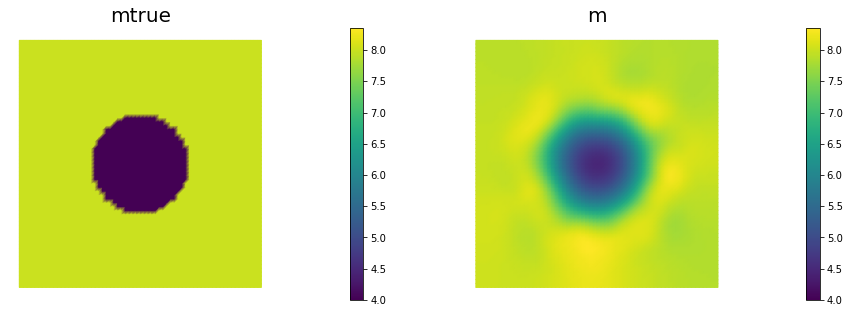

****** Computing solution with gamma =  1e-10 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     3.55408e-06   3.55408e-06   3.17206e-13   8.34768e-03   2.92667e-05    1.00   5.000e-01
 2     1     2.03543e-06   2.03543e-06   2.02791e-13   1.72174e-03   6.56433e-06    1.00   4.736e-01
 3     4     1.31852e-06   1.31663e-06   1.88952e-09   1.28132e-03   2.41818e-06    1.00   2.874e-01
 4     1     1.24021e-06   1.23831e-06   1.89028e-09   3.96009e-04   1.34513e-06    1.00   2.144e-01
 5    14     1.20220e-06   1.19743e-06   4.77157e-09   3.23746e-04   3.55552e-07    1.00   1.102e-01
 6     1     1.19070e-06   1.18593e-06   4.77161e-09   1.54588e-04   5.74504e-07    1.00   1.401e-01
 7    10     1.18808e-06   1.18274e-06   5.34394e-09   7.17956e-05   9.65659e-08    1.00   5.744e-02
 8    20     1.18590e-06   1.17809e-06   7.80636e-09   8.44687e-05   5.33754e-08    1.00   4.271e-02
 9     1     1.18474e-06   1.17694e-06   7

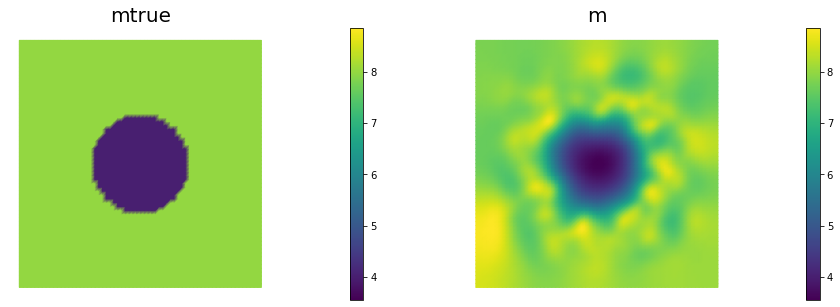

'\nfor n in ns:\n    ndof, niter, ncgiter, _,_,_,_ = AddDiffInverseProblem(nx=n, ny=n, v=dl.Constant((30., 0.)), gamma = 1e-9)\n    niters.append(niter)\n    ncgiters.append(ncgiter)\n    ndofs.append(ndof)\n\nplt.figure(figsize=(15,5))\nplt.subplot(121)\nplt.semilogx(ndofs, niters)\nplt.ylim([0, 12])\nplt.xlabel("Parameter dimension")\nplt.ylabel("Number of Newton iterations")\nplt.subplot(122)\nplt.semilogx(ndofs, ncgiters)\nplt.ylim([0, 150])\nplt.xlabel("Parameter dimension")\nplt.ylabel("Number of CG iterations")\nplt.show()\n'

In [14]:
n = 40
gammas = [1e-7, 1e-8, 1e-9, 1e-10]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(nx, ny, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.10, useTV=False)
    
'''
for n in ns:
    ndof, niter, ncgiter, _,_,_,_ = AddDiffInverseProblem(nx=n, ny=n, v=dl.Constant((30., 0.)), gamma = 1e-9)
    niters.append(niter)
    ncgiters.append(ncgiter)
    ndofs.append(ndof)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.semilogx(ndofs, niters)
plt.ylim([0, 12])
plt.xlabel("Parameter dimension")
plt.ylabel("Number of Newton iterations")
plt.subplot(122)
plt.semilogx(ndofs, ncgiters)
plt.ylim([0, 150])
plt.xlabel("Parameter dimension")
plt.ylabel("Number of CG iterations")
plt.show()
'''

****** Computing solution with gamma =  1e-07 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40043e-06   2.40011e-06   3.17859e-10   8.35779e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87596e-07   8.87394e-07   2.01775e-10   1.71777e-03   6.61722e-06    1.00   4.753e-01
 3     2     6.40774e-07   4.93711e-07   1.47063e-07   7.08506e-04   2.47713e-06    1.00   2.908e-01
 4     2     6.23460e-07   4.75595e-07   1.47865e-07   1.85464e-04   6.29992e-07    1.00   1.466e-01
 5     3     6.22202e-07   4.53490e-07   1.68712e-07   4.99122e-05   1.74728e-07    1.00   7.723e-02
 6     5     6.22188e-07   4.54203e-07   1.67985e-07   5.35451e-06   2.86138e-08    1.00   3.125e-02
 7     5     6.22188e-07   4.54175e-07   1.68012e-07   1.13723e-07   4.85920e-10    1.00   4.073e-03
Newton's method converged in  7   iterations
Total number of CG iterations:  19


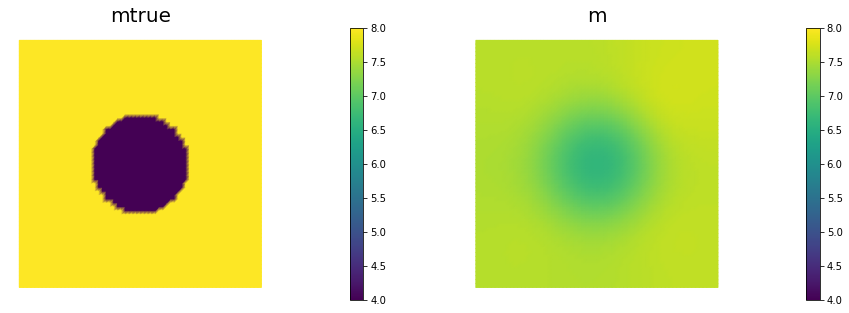

****** Computing solution with gamma =  1e-08 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40026e-06   2.40023e-06   3.17864e-11   8.35782e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87438e-07   8.87418e-07   2.02721e-11   1.71776e-03   6.57852e-06    1.00   4.739e-01
 3     4     2.58000e-07   1.29821e-07   1.28179e-07   1.17692e-03   2.45624e-06    1.00   2.896e-01
 4     1     2.22724e-07   9.45056e-08   1.28218e-07   2.65630e-04   9.53987e-07    1.00   1.805e-01
 5     8     2.17274e-07   8.84267e-08   1.28847e-07   1.06269e-04   2.18875e-07    1.00   8.644e-02
 6     5     2.17229e-07   8.88363e-08   1.28392e-07   9.52830e-06   2.05604e-08    1.00   2.649e-02
 7    11     2.17227e-07   8.87431e-08   1.28484e-07   1.54419e-06   3.82498e-09    1.00   1.143e-02
Newton's method converged in  7   iterations
Total number of CG iterations:  31


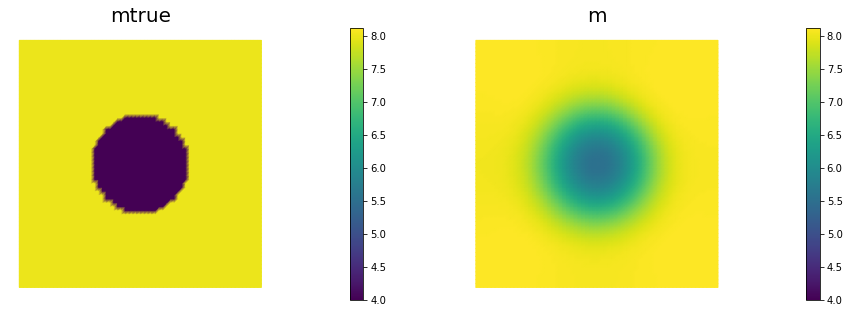

****** Computing solution with gamma =  1e-09 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40025e-06   2.40025e-06   3.17864e-12   8.35782e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87422e-07   8.87420e-07   2.02816e-12   1.71776e-03   6.57466e-06    1.00   4.738e-01
 3     4     1.57640e-07   1.38912e-07   1.87278e-08   1.28998e-03   2.45417e-06    1.00   2.894e-01
 4     1     8.16579e-08   6.29227e-08   1.87352e-08   3.90046e-04   1.32922e-06    1.00   2.130e-01
 5    10     5.67562e-08   2.60760e-08   3.06802e-08   2.36372e-04   3.08177e-07    1.00   1.026e-01
 6     1     5.56556e-08   2.49750e-08   3.06806e-08   4.71613e-05   1.73272e-07    1.00   7.691e-02
 7    18     5.44608e-08   2.32601e-08   3.12008e-08   4.89628e-05   5.74841e-08    1.00   4.430e-02
 8     1     5.44574e-08   2.32566e-08   3.12008e-08   2.62863e-06   1.07642e-08    1.00   1.917e-02
 9    32     5.44499e-08   2.33249e-08   3

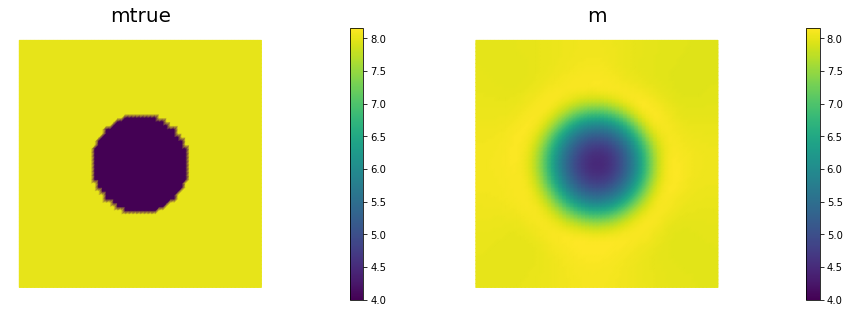

****** Computing solution with gamma =  1e-10 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40024e-06   2.40024e-06   3.17743e-13   8.35783e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87410e-07   8.87410e-07   2.02753e-13   1.71777e-03   6.57428e-06    1.00   4.737e-01
 3     4     1.46148e-07   1.44195e-07   1.95357e-09   1.30326e-03   2.45394e-06    1.00   2.894e-01
 4     1     6.33682e-08   6.14138e-08   1.95437e-09   4.07134e-04   1.38062e-06    1.00   2.171e-01
 5    15     2.97626e-08   2.53070e-08   4.45568e-09   2.96945e-04   3.29999e-07    1.00   1.061e-01
 6     1     2.18906e-08   1.74348e-08   4.45575e-09   1.27439e-04   4.70462e-07    1.00   1.267e-01
 7    15     1.94352e-08   1.39266e-08   5.50857e-09   6.84750e-05   6.83532e-08    1.00   4.831e-02
 8     1     1.93752e-08   1.38666e-08   5.50858e-09   1.09669e-05   4.51165e-08    1.00   3.924e-02
 9    58     1.89616e-08   1.31136e-08   5

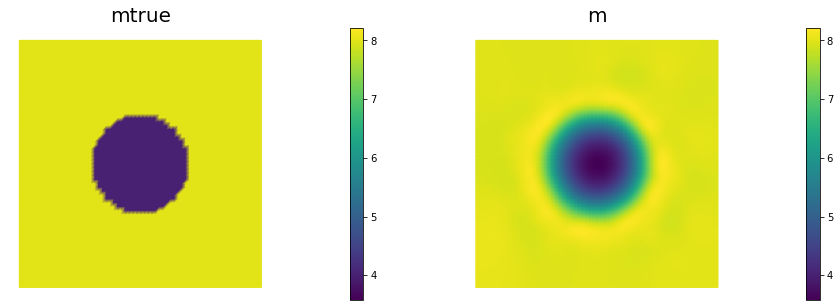

In [15]:
n = 40
gammas = [1e-7, 1e-8, 1e-9, 1e-10]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(nx, ny, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=False)

# Part 2.4: Tikhonov regularization with total variation regularization $\delta=0.001$

****** Computing solution with gamma =  1e-08 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40103e-06   2.40023e-06   8.01493e-10   8.35782e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.88070e-07   8.87399e-07   6.71391e-10   1.71785e-03   6.61474e-06    1.00   4.752e-01
 3     4     1.63281e-07   1.28348e-07   3.49336e-08   1.19957e-03   2.47600e-06    1.00   2.907e-01
 4     1     1.25022e-07   9.00745e-08   3.49475e-08   2.76665e-04   1.08031e-06    1.00   1.920e-01
 5     8     8.26545e-08   4.34241e-08   3.92305e-08   2.58019e-04   4.74402e-07    1.00   1.273e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  15


FileNotFoundError: [Errno 2] No such file or directory: 'Figures/HW5_Q2_TV_6.4e+01_1.0e-08_.pdf'

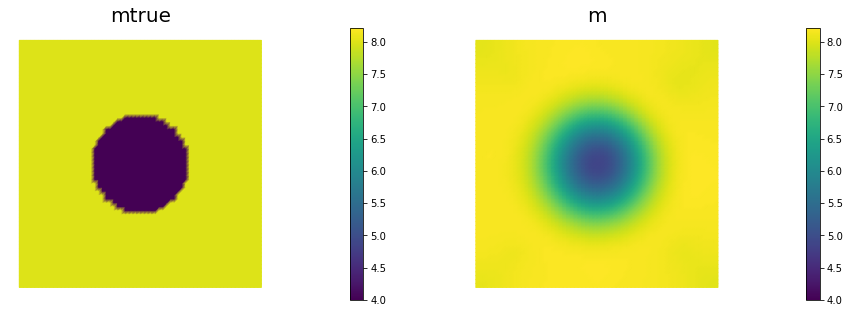

In [39]:
n = 20
gammas = [1e-8,1e-9, 1e-10,1e-11]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(nx, ny, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=True)


****** Computing solution with gamma =  1e-08 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40103e-06   2.40023e-06   8.01493e-10   8.35782e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.88070e-07   8.87399e-07   6.71391e-10   1.71785e-03   6.61474e-06    1.00   4.752e-01
 3     4     1.63281e-07   1.28348e-07   3.49336e-08   1.19957e-03   2.47600e-06    1.00   2.907e-01
 4     1     1.25022e-07   9.00745e-08   3.49475e-08   2.76665e-04   1.08031e-06    1.00   1.920e-01
 5     8     8.26545e-08   4.34241e-08   3.92305e-08   2.58019e-04   4.74402e-07    1.00   1.273e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  15


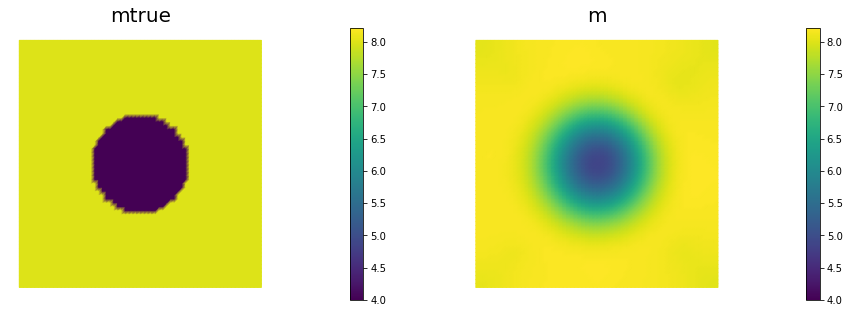

****** Computing solution with gamma =  1e-09 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40033e-06   2.40025e-06   8.01494e-11   8.35782e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87486e-07   8.87419e-07   6.72693e-11   1.71777e-03   6.57826e-06    1.00   4.739e-01
 3     4     1.43514e-07   1.39419e-07   4.09488e-09   1.29242e-03   2.45610e-06    1.00   2.896e-01
 4     1     6.69365e-08   6.28403e-08   4.09623e-09   3.91574e-04   1.33931e-06    1.00   2.138e-01
 5    10     2.92000e-08   2.42841e-08   4.91588e-09   2.73002e-04   3.36900e-07    1.00   1.072e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  17


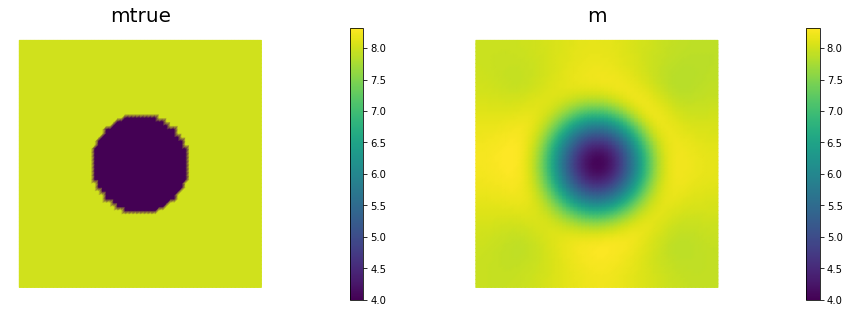

****** Computing solution with gamma =  1e-10 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40025e-06   2.40024e-06   8.01373e-12   8.35783e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87417e-07   8.87410e-07   6.72733e-12   1.71777e-03   6.57464e-06    1.00   4.737e-01
 3     4     1.44672e-07   1.44255e-07   4.17052e-10   1.30351e-03   2.45413e-06    1.00   2.894e-01
 4     1     6.18278e-08   6.14106e-08   4.17188e-10   4.07292e-04   1.38161e-06    1.00   2.172e-01
 5    15     2.63080e-08   2.57680e-08   5.39941e-10   3.01543e-04   3.32874e-07    1.00   1.066e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  22


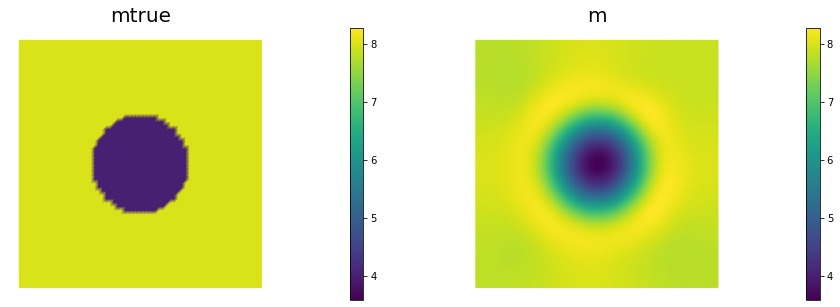

****** Computing solution with gamma =  1e-11 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40024e-06   2.40024e-06   8.01368e-13   8.35783e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87410e-07   8.87409e-07   6.72745e-13   1.71777e-03   6.57427e-06    1.00   4.737e-01
 3     3     1.42894e-07   1.42853e-07   4.17824e-11   1.30448e-03   2.45393e-06    1.00   2.894e-01
 4     1     6.13424e-08   6.13006e-08   4.17957e-11   4.04102e-04   1.37055e-06    1.00   2.163e-01
 5    14     2.68363e-08   2.67814e-08   5.48819e-11   3.04979e-04   3.32660e-07    1.00   1.066e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  20


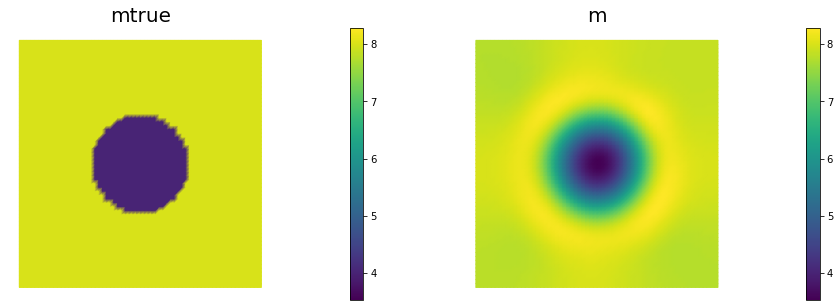

In [45]:
n = 40
gammas = [1e-8,1e-9, 1e-10,1e-11]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(nx, ny, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=True)

In [ ]:
n = 80
gammas = [1e-9, 1e-10]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(nx, ny, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=True)

Copyright &copy; 2016-2018, The University of Texas at Austin & University of California, Merced.<br>
Copyright &copy; 2019, The University of Texas at Austin, University of California--Merced, Washington University in St. Louis. <br>
All Rights reserved.<br>
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.